In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.parse

In [2]:
import os, sys

# HTLM files URLs in a list 
wp_path = "/Users/ginevralarroux/Desktop/EPFL courses/Applied data analysis/ADA project/data/wpcd/wp/" # to adapt
directories = os.listdir(wp_path)
html_list = []
for dir in directories:
    local_path = wp_path + dir
    local_dir = os.listdir(local_path)
    for link in local_dir:
        if link[-3:]=='htm':
            html_list.append(dir+'/'+link)
html_list[:10]

['r/Royal_Marines.htm',
 'r/Recycling.htm',
 'r/Retreat_of_glaciers_since_1850.htm',
 'r/Remember_Girls_Like_Rajpura.htm',
 'r/Rutherfordium.htm',
 'r/Rule_of_St_Benedict.htm',
 'r/Red_dwarf.htm',
 'r/Romeo_and_Juliet.htm',
 'r/Rudyard_Kipling.htm',
 'r/Race.htm']

The aim of this specific game strategy analysis is to test whether Wikispeedia players have clikability preferences on the basis of the hyperlinks' positioning throughout the article text. 
In particular:
1. we wil find the ordinal number of the paragraph each hyperlink in an article shows up in and divide it by the total number of paragraphs of the article, to determine its positioning; 
2. we will determine if each hyperlink in an article shows up in an image captions.
We will then investigate if there is a correlation between the clickability of the hyperlinks and their location, using the proper statistical tests. 

It is therefore essential to extract from the data the number of clicks for each hyperlink.

In [3]:
# read files 
folder='/Users/ginevralarroux/Desktop/EPFL courses/Applied data analysis/ADA project/data/wikispeedia_paths-and-graph/'

paths_finished='paths_finished.tsv'
paths_unfinished='paths_unfinished.tsv'
articles='articles.tsv'

paths_finished=pd.read_csv(folder+paths_finished, sep='\t', skiprows=15, header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
paths_unfinished=pd.read_csv(folder+paths_unfinished, sep='\t', skiprows=16, header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'])
articles=pd.read_csv(folder+articles, sep='\t', skiprows=12, header=None, names=['article'])

The dataframe `paths_finished` contains the paths chosen by the players who could reach the target article.

In [4]:
paths_finished.head()

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


The dataframe `paths_unfinished` contains the paths chosen by the players who could not reach the target article.

In [5]:
paths_unfinished.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout


The dataframe `articles` lists all the clickable articles/links.

In [6]:
# encode and filter link names
def filter_link_list(links_list):
    new_links_list=[]
    for link in links_list:
        link=urllib.parse.unquote(link)
        link=link.lower()
        link=link.replace('_', ' ')
        link=link.strip()
        new_links_list.append(link)
    return new_links_list

articles.article=filter_link_list(articles.article)
articles.head(10)

,article
0,áedán mac gabráin
1,åland
2,édouard manet
3,éire
4,óengus i of the picts
5,€2 commemorative coins
6,10th century
7,11th century
8,12th century
9,13th century


In [7]:
print('The total number of articles comprising the Wikispeedia library is {0}.'.format(len(articles)))

The total number of articles comprising the Wikispeedia library is 4604.


The dataframe `clicked_links_filtered` contains the clicked links troughout the paths.

In [8]:
clicked_links=[]
for x in paths_finished['path']: 
    path=(x.split(';')) # get list of links along the path string 
    clicked_links.append(path)

clicked_links_filtered=[] # consistent with other dfs
for path in clicked_links:
    path_filtered=filter_link_list(path)
    if '<' in path: 
        path.remove('<') # remove backclicks
    clicked_links_filtered.append(path_filtered)

clicked_links_filtered[:5]

[['14th century',
  '15th century',
  '16th century',
  'pacific ocean',
  'atlantic ocean',
  'accra',
  'africa',
  'atlantic slave trade',
  'african slave trade'],
 ['14th century',
  'europe',
  'africa',
  'atlantic slave trade',
  'african slave trade'],
 ['14th century',
  'niger',
  'nigeria',
  'british empire',
  'slavery',
  'africa',
  'atlantic slave trade',
  'african slave trade'],
 ['14th century', 'renaissance', 'ancient greece', 'greece'],
 ['14th century',
  'italy',
  'roman catholic church',
  'hiv',
  'ronald reagan',
  'president of the united states',
  'john f. kennedy']]

The dataframe `links_freq_df` contains the links' frequency of clicks.

In [9]:
links_name=[]
links_freq=[]

i=0
for article in articles['article']: # count the number of times each article shows up in paths
    count=0
    links_name.append(article)
    for i in range(len(clicked_links_filtered)):
        if article in clicked_links_filtered[i]:
            count+=1 
    links_freq.append(count)

links_name=pd.Series(links_name)
links_freq=pd.Series(links_freq)
links_freq_df=pd.concat([links_name, links_freq], axis=1, names=['link', '#_clicks'])
links_freq_df.columns=['link', '#_clicks']
links_freq_df.loc[links_freq_df['#_clicks']!=0].head()

,link,#_clicks
1,åland,2
2,édouard manet,2
3,éire,3
5,€2 commemorative coins,1
6,10th century,109


In [10]:
clicks_tot=links_freq_df['#_clicks'].sum()
print('The total number of clicked hyperlinks is {0}.'.format(clicks_tot))

The total number of clicked hyperlinks is 321717.


Next step of the descriptive analysis process is the HTML files parsing aimed at determining the location of hyperlinks. 

In [11]:
# parse html files 

from bs4 import BeautifulSoup

soups=[]
failed_html_list = []
for html in html_list[:]:
    f=open(wp_path+html, 'r')
    try:
        soup = BeautifulSoup(f, 'lxml')
        soups.append(soup)
    except Exception:
        failed_html_list.append(html)

In [12]:
print('{0} files were not parsable. However, they are not reachable nor it is possible to click \
any hyperlink in those html pages.'.format(len(failed_html_list)))

53 files were not parsable. However, they are not reachable nor it is possible to click any hyperlink in those html pages.


`link_positioning_dfs` is a list of dataframes (`link_positioning_df`) containing hyperlinks showing up in one html file, the ordinal number of the paragraph they belong to and their relative positioning troughout the article text. 

In [13]:
# HTML tag for hyperlinks is <a href= >
# the function finds all <a href= > tags throughout the article html file

def find_links(soup): 
    paragraphs = soup.find_all('p') 
    links=[]
    i=0
    for p in paragraphs:
        i+=1
        all_links=p.find_all('a')
        for link in all_links:
            if 'href' in link.attrs:
                link_title=link.text
                link_paragraph=i
                links.append([link_title, link_paragraph])
                
    link_positioning_df=pd.DataFrame(links, columns=['link', '#_paragraph']).drop_duplicates()
    link_positioning_df['positioning']=round(link_positioning_df['#_paragraph']/len(paragraphs), 2)
    link_positioning_df['link']=filter_link_list(link_positioning_df['link'])
    return link_positioning_df

In [14]:
# apply the function to all html files

link_positioning_dfs=[]
for soup in soups:
    link_positioning_dfs.append(find_links(soup))

link_positioning_dfs[:5]

[                              link  #_paragraph  positioning
 0                       royal navy            1         0.01
 1                   united kingdom            1         0.01
 2                         cold war           18         0.19
 3                     sierra leone           20         0.21
 4                         dartmoor           24         0.25
 5                     world war ii           29         0.30
 6                         plymouth           34         0.35
 7                         scotland           34         0.35
 8                        gibraltar           43         0.44
 9                             cuba           44         0.45
 10               george washington           44         0.45
 11                      royal navy           45         0.46
 13                      portsmouth           46         0.47
 14                        plymouth           46         0.47
 15      american revolutionary war           46         0.47
 16     

In [15]:
print('{0} number of html files were parsed.'.format(len(link_positioning_dfs)))

5409 number of html files were parsed.


In [16]:
# example with 2 files

URL_1 = wp_path+'a/A_cappella.htm'
URL_2 = wp_path+'m/Music.htm'

f1=open(URL_1, 'r')
soup1 = BeautifulSoup(f1, 'lxml')

f2=open(URL_2, 'r')
soup2 = BeautifulSoup(f2, 'lxml')

link_positioning_df_1=find_links(soup1).drop(labels='#_paragraph', axis=1)
link_positioning_df_2=find_links(soup2).drop(labels='#_paragraph', axis=1)

# merging the 2 dataframes

merged_dfs=link_positioning_df_1.merge(link_positioning_df_2, how='outer', left_on='link', right_on='link', )
merged_dfs

,link,positioning_x,positioning_y
0,music,0.04,NaN
1,instrumental,0.04,NaN
2,renaissance,0.04,NaN
3,renaissance,0.12,NaN
4,gregorian chant,0.12,NaN
5,amish,0.21,NaN
6,eastern orthodox,0.21,NaN
7,jewish,0.33,NaN
8,beatles,0.75,NaN
9,hindi,0.88,NaN


In [17]:
# merge all the link_positioning_df in link_positioning_dfs list by hyperlink in order to apply a function 
# that determines the "average" positioning of the hyperlinks

for df in link_positioning_dfs:
    try:
        df.drop(labels='#_paragraph', axis=1, inplace=True)  # remove not needed column
    except:
        pass    

link_positioning_dfs=link_positioning_dfs[:100]
from functools import reduce # perform multiple merge
links_pos_dfs_merged = reduce(lambda  left,right: pd.merge(left,right,on=['link'],how='outer'), link_positioning_dfs)
links_pos_dfs_merged.head()

/var/folders/98/5x9_sw_93w565h0fcpcfq0f40000gn/T/ipykernel_35347/1720511123.py:12: FutureWarning: Passing 'suffixes' which cause duplicate columns {'positioning_x'} in the result is deprecated and will raise a MergeError in a future version.
  links_pos_dfs_merged = reduce(lambda  left,right: pd.merge(left,right,on=['link'],how='outer'), link_positioning_dfs)
/var/folders/98/5x9_sw_93w565h0fcpcfq0f40000gn/T/ipykernel_35347/1720511123.py:12: FutureWarning: Passing 'suffixes' which cause duplicate columns {'positioning_x'} in the result is deprecated and will raise a MergeError in a future version.
  links_pos_dfs_merged = reduce(lambda  left,right: pd.merge(left,right,on=['link'],how='outer'), link_positioning_dfs)
/var/folders/98/5x9_sw_93w565h0fcpcfq0f40000gn/T/ipykernel_35347/1720511123.py:12: FutureWarning: Passing 'suffixes' which cause duplicate columns {'positioning_x'} in the result is deprecated and will raise a MergeError in a future version.
  links_pos_dfs_merged = reduce(la

,link,positioning_x,positioning_y,positioning_x,positioning_y,positioning_x,positioning_y,positioning_x,positioning_y,positioning_x,...,positioning_x,positioning_y,positioning_x,positioning_y,positioning_x,positioning_y,positioning_x,positioning_y,positioning_x,positioning_y
0,royal navy,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,royal navy,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,royal navy,0.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,royal navy,0.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,royal navy,0.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# function that determines the most frequent positioning of each hyperlink in the set of all links

def find_positioning(array):
    bin_labels=['top', 'center', 'bottom'] # positioning is classified as top, center or bottom of the article
    bins=[0, 0.33, 0.66, 1] 
    cut_positioning=pd.cut(array, bins, labels=bin_labels)
    positioning_frequency=pd.value_counts(cut_positioning) # frequency of the bins
    most=positioning_frequency.apply('max') # bin with highest frequency
    if len(positioning_frequency[positioning_frequency==most])>1:
        return np.random.choice(positioning_frequency[positioning_frequency==most].index.values.astype(str)) #account for same frequency
    else:
        return positioning_frequency[positioning_frequency==most].index.values.astype(str).item()

The dataframe `most_freq_positioning_df` contains the hyperlinks most frequent positioning.

In [19]:
# example with 2 files

most_freq_positioning_2=merged_dfs.groupby(by=merged_dfs['link']).apply(lambda x: find_positioning(np.array(x.values).flatten()))
most_freq_positioning_df_2=pd.DataFrame(most_freq_positioning_2, columns=['most_freq_positioning'])
most_freq_positioning_df_2=most_freq_positioning_df_2.reset_index()
most_freq_positioning_df_2

,link,most_freq_positioning
0,aesthetic,top
1,amish,top
2,anthropology,bottom
3,art,top
4,artistic,top
5,beatles,bottom
6,beethoven,top
7,bluegrass,top
8,communicative,top
9,culture,top


In [20]:
# all html files

most_freq_positioning=links_pos_dfs_merged.set_index("link").groupby("link").apply(lambda x: find_positioning(x.values.flatten()))
most_freq_positioning_df=pd.DataFrame(most_freq_positioning, columns=['most_freq_positioning'])
most_freq_positioning_df

,most_freq_positioning
link,
,bottom
"""ruffian dick""",top
(france),bottom
(uk),bottom
13th century,top
...,...
zeus,top
zimbabwe,bottom
zionist,center


The dataframe `links_freq_pos` contains both the hyperlinks' most frequent positioning and their frequency of clicks.

In [21]:
links_freq_pos=links_freq_df.merge(most_freq_positioning_df, how='outer', left_on='link', right_on='link')
links_freq_pos

,link,#_clicks,most_freq_positioning
0,áedán mac gabráin,0.0,NaN
1,åland,2.0,NaN
2,édouard manet,2.0,NaN
3,éire,3.0,NaN
4,óengus i of the picts,0.0,NaN
...,...,...,...
5085,work in india,NaN,bottom
5086,world war 2,NaN,top
5087,wwii,NaN,center
5088,zionist,NaN,center


The dataframe `links_freq_pos_grouped_df` groups the hyperlinks click frequency by their positioning.

In [22]:
links_freq_pos_grouped=links_freq_pos['#_clicks'].groupby(links_freq_pos['most_freq_positioning']).sum()
links_freq_pos_grouped_df=pd.DataFrame(links_freq_pos_grouped)
links_freq_pos_grouped_df

,#_clicks
most_freq_positioning,
bottom,36716.0
center,35773.0
top,100371.0


In [23]:
# normalization

links_freq_pos_grouped_df['#_clicks_norm']=links_freq_pos_grouped_df['#_clicks']/clicks_tot
links_freq_pos_grouped_df

,#_clicks,#_clicks_norm
most_freq_positioning,,
bottom,36716.0,0.114125
center,35773.0,0.111194
top,100371.0,0.311985


The dataframe `positioning_freq_df_grouped` contains the frequency of hyperlinks showing up in the Wikispeedia set of articles grouped by their positioning throughout the text. 

In [24]:
# function that counts the frequency of a link showing up at the top, center, bottom of the article

def find_positioning_dis(array):
    bin_labels=['top', 'center', 'bottom']
    bins=[0, 0.33, 0.66, 1]
    cut_positioning=pd.cut(array, bins, labels=bin_labels)
    positioning_frequency=pd.value_counts(cut_positioning)
    return positioning_frequency

In [25]:
# apply the function to the dataframe links positioning grouped by link  
positioning_freq=links_pos_dfs_merged.set_index("link").groupby("link").apply(lambda x: find_positioning_dis(x.values.flatten()))
positioning_freq_df=pd.DataFrame(positioning_freq, columns=['positioning_freq'])
positioning_freq_df.reset_index(level=1, inplace=True)
positioning_freq_df.rename(columns={'level_1':'positioning'}, inplace=True)
positioning_freq_df.head(20)

,positioning,positioning_freq
link,,
,bottom,22
,top,11
,center,11
"""ruffian dick""",top,1
"""ruffian dick""",center,0
"""ruffian dick""",bottom,0
(france),bottom,1
(france),top,0
(france),center,0


In [26]:
positioning_freq_df_grouped=positioning_freq_df.groupby('positioning').sum()
positioning_freq_df_grouped.columns=['nr']
links_tot=np.sum(positioning_freq_df['positioning_freq'])
positioning_freq_df_grouped['nr_norm']=positioning_freq_df_grouped['nr']/links_tot
positioning_freq_df_grouped

,nr,nr_norm
positioning,,
top,10252,0.564134
center,3449,0.189787
bottom,4472,0.246079


The bar plots show the distribution of the hyperlinks positioning. On the left side, the clicked ones and the total number of links in the articles, both normalized. On the right side, the former relative to the latter frequency.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Frequency normalized')

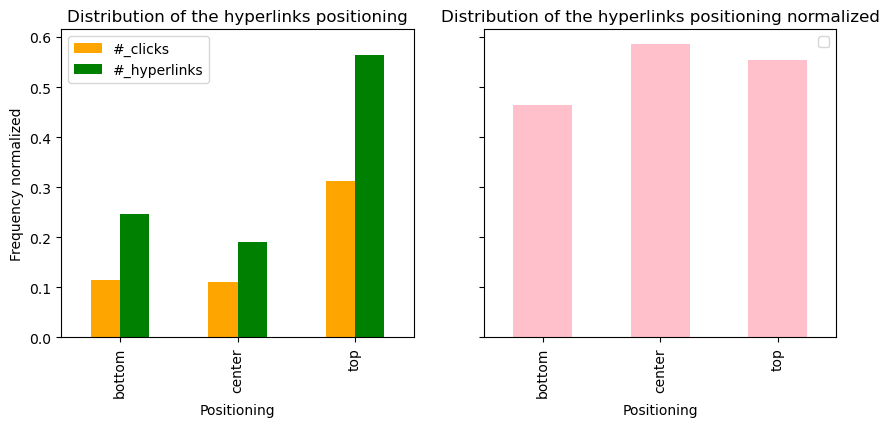

In [27]:
# visualization of the Distribution of the clicked hyperlinks' positioning

# dataframe for visualization
vis=links_freq_pos_grouped_df.merge(positioning_freq_df_grouped, left_index=True, right_index=True)

fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,4))
vis.plot(y=['#_clicks_norm', 'nr_norm'], kind='bar', ax=ax[0], label=['#_clicks', '#_hyperlinks'], color=['orange', 'green'])
ax[0].legend()
ax[0].set_title('Distribution of the hyperlinks positioning')
ax[0].set_xlabel('Positioning')
ax[0].set_ylabel('Frequency normalized')

vis['clicked']=vis['#_clicks_norm']/vis['nr_norm']
vis.plot(y='clicked', kind='bar', ax=ax[1], color='pink', label='')
ax[1].legend()
ax[1].set_title('Distribution of the hyperlinks positioning normalized')
ax[1].set_xlabel('Positioning')
ax[1].set_ylabel('Frequency normalized')

The following part of the descriptive analysis focuses on the location of hyperlinks in images' captions.

Images in html files can be either found under \<div> tag or \<table> tag, while the hyperlinks are found in their captions under \<div class='thumbcaption'> tag.

In [29]:
# parse html file and search hyperlinks in the captions of tables containing images 

def find_link_in_table(soup):
    
    tables = soup.find_all('table')

    links=[]
    for table in tables:
        if table.find('img'):
            all_links=table.find_all('a')
            for link in all_links:
                if 'class' not in link.attrs:
                    link_title=link.text
                    links.append(link_title)

    if links:
        links_in_table_df=pd.DataFrame(links).drop_duplicates()
        links_in_table_df.columns=['link']
        links_in_table_df=links_in_table_df.apply(filter_link_list) 
    else: 
        return None
    return links_in_table_df

The dataframe `links_in_tables` contains the links showing up in tables' captions. 

In [30]:
links_in_tables=[]
for soup in soups:
    links_in_tables.append(find_link_in_table(soup))

links_in_tables=pd.concat(links_in_tables, axis=0)
links_in_tables.head()

,link
0,royal navy
1,united kingdom
3,plymouth
4,latin
0,lawrencium


In [31]:
links_in_tables_tot=len(links_in_tables)
print('The total number of links in tables captions is {0}'.format(links_in_tables_tot))

The total number of links in tables captions is 15159


In [32]:
# parse html file and search hyperlinks in the captions of tables containing images 

def find_links_in_img(soup):
    div = soup.find_all('div')

    links=[]

    for d in div:
        if (d.find('a', class_="internal")):
            if (d.find('img', class_='thumbimage')):
                caption=d.find('div', class_="thumbcaption")
                if (caption.find('a')):
                    all_links=caption.find_all('a')
                    for link in all_links:
                        if 'class' not in link.attrs:
                            link_title=link.text
                            links.append(link_title)
    if links:
        links_in_image_df=pd.DataFrame(links).drop_duplicates()
        links_in_image_df.columns=['link']
        links_in_image_df=links_in_image_df.apply(filter_link_list) 
    else: 
        return None
        links_in_image_df=pd.DataFrame()
    return links_in_image_df

The dataframe `links_in_images` contains the links showing up in images' captions. 

In [33]:
links_in_images=[]
for soup in soups:
    links_in_images.append(find_links_in_img(soup))

links_in_images=pd.concat(links_in_images, axis=0)
links_in_images.head()

,link
0,bangladesh
0,portsmouth
2,england
4,india
0,pompeii


In [34]:
links_in_images_tot=len(links_in_images)
print('The total number of links in tables captions is {0}.'.format(links_in_images_tot))

The total number of links in tables captions is 372.


In [ ]:
links_in_images=links_in_images.reset_index(drop=True).drop_duplicates()
links_in_tables=links_in_tables.reset_index(drop=True).drop_duplicates()

In [ ]:
# link in image

flag_img=[]
links_freq_img=links_freq_df.copy()

for link in links_freq_img['link']:
    if link in list(links_in_images['link']):
        flag_img.append(1)
    else:
        flag_img.append(0)
    
links_freq_img['in_image']=flag_img
links_freq_img[links_freq_img['in_image']==1][:10]

In [ ]:
# link in table

flag_tab=[]
links_freq_tab=links_freq_df.copy()

for link in links_freq_tab['link']:
    if link in list(links_in_tables['link']):
        flag_tab.append(1)
    else:
        flag_tab.append(0)
    
links_freq_tab['in_tab']=flag_tab
links_freq_tab[links_freq_tab['in_tab']==1][:10]

In [ ]:
links_freq_img_grouped_df=pd.DataFrame(links_freq_img['#_clicks'].groupby(links_freq_img['in_image']).sum())
links_freq_img_grouped_df.loc[0,'#_clicks_norm_img']=links_freq_img_grouped_df.loc[0,'#_clicks']/(links_tot-links_in_images_tot)
links_freq_img_grouped_df.loc[1,'#_clicks_norm_img']=links_freq_img_grouped_df.loc[1,'#_clicks']/links_in_images_tot
links_freq_img_grouped_df

In [ ]:
links_freq_tab_grouped_df=pd.DataFrame(links_freq_tab['#_clicks'].groupby(links_freq_tab['in_tab']).sum())
links_freq_tab_grouped_df.loc[0,'#_clicks_norm_tab']=links_freq_tab_grouped_df.loc[0,'#_clicks']/(links_tot-links_in_tables_tot)
links_freq_tab_grouped_df.loc[1,'#_clicks_norm_tab']=links_freq_tab_grouped_df.loc[1,'#_clicks']/links_in_tables_tot
links_freq_tab_grouped_df

In [ ]:
# dataframe for visualization

vis_img=links_freq_img_grouped_df.merge(links_freq_tab_grouped_df, left_index=True, right_index=True)

fig, ax = plt.subplots(figsize=(6,4))
vis_img.plot(y=['#_clicks_norm_img', '#_clicks_norm_tab'], kind='bar', ax=ax, label=['image', 'table'], color=['orange', 'green'])
ax.legend()
ax.set_title('Distribution of the hyperlinks clickability')
ax.set_xlabel('Link in image or table caption')
ax.set_ylabel('Frequency normalized')


In [ ]:
# assumptions: 
# we don't know for the hyperlinks that show up both in the article text and in the image caption, 
# which the player actually clicked 
# for the hyperlinks which show up multiple times in the article ...